# Logistic regression with pymc

Through this notebook we will develop a series of classification experiments taking advantage of bayesian logistic regression. For the sake of clarity, we will be employing sythetic datasets in each of the cases. We will do so with the support of PyMC, a probabilistic programming library for Python that allows users to build Bayesian models with a simple Python API and fit them using Markov chain Monte Carlo (MCMC) methods (ref: https://www.pymc.io/welcome.html). PyMC3 is written using Python, where the computationally demanding parts are written using NumPy and Theano. Theano is a Python library originally developed for deep learning that allows us to define, optimize, and evaluate mathematical expressions involving multidimensional arrays efficiently. The main reason PyMC3 uses Theano is because some of the sampling methods, like NUTS, need gradients to be computed and Theano can deal efficiently with automatic differentiation. Also, Theano compiles Python code to C code, and hence PyMC3 is really fast (ref:Bayesian Analysis with Python).

## 0. Setup

We load needed libraries. Besides PyMC and some classic python libraries suited for working with data, such us `pandas` or `numpy`, and some also customary visualization python tools such us `matplotlib` and `seaborn`, we import ArviZ (ref: https://arviz-devs.github.io/arviz/), a Python package for exploratory analysis of Bayesian models that includes functions for posterior analysis, data storage, sample diagnostics, model checking, and comparison.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pymc as pm
import arviz as az

We will be working with PyMC last version:

In [2]:
print("PyMC version:", pm.__version__)

PyMC version: 4.0.0


## 1. Binary univariate classification

We start by the most simple case, a two-class classification , i.e., $y \in \{0,1\}$ with just one feature, i.e., $x \in \mathbb R$. We will simulate two clusters of size 50 each following a normal distribution, the first one centred on 2.5 and the second one centered on 4, with a standard deviation of 1 for both of them:

In [3]:
N = 50
K=1

In [4]:
x1 = np.random.normal(2.5, 1, N)
x2 = np.random.normal(4, 1, N)
data = pd.DataFrame([x1, x2]).T
data.head()

,0,1
0,2.273973,4.310976
1,3.149624,3.849423
2,1.530589,4.786334
3,2.455487,3.047203
4,2.539761,4.062246


We can observe the distribution of our two 1-dimensional clusters with a violin plot:

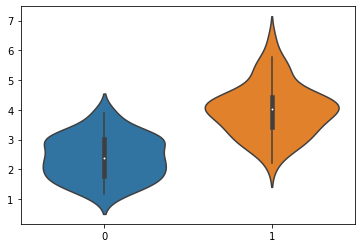

In [5]:
sns.violinplot(data=data)
plt.show()

In [6]:
x_0 = np.concatenate([x1, x2]).reshape((2*N, 1))
y_0 = np.concatenate([np.zeros(N), np.ones(N)]).astype(int)

Now that we have the data, we need to specify the model, that is, our prior distribution and likelihood. As the likelihood, we will chose a Bernoulli $(p= \theta )$ distribution ....

The model is defined with PyMC as follows:

- `line 1`: creates a container for our model, using the `with` statement to indicate that everything inside the with block points to the same model, `model_0`.
- `lines 2-4`: specifies the priors for $\alpha$ and $\beta$, and $\mu$ is defined as the line $\alpha + x_0\beta$, being $x_0$ our previously generated data points.
- `lines 5-6`: $\theta$ is deterministically defined (fully determined by its arguments) as the sigma function applied to $\mu$, and the classification decision boundary is simply defined as $-\frac{\alpha}{\beta}$ (i.e., $x : logistic(\alpha + x\beta)=0.5$).
- `line 7`:  specifies the likelihood following the same syntax as for the prior, except that we pass the data using the observed argument. The data can be a Python list, a
NumPy array or a Pandas DataFrame. Here we pass $y_0$ as the observed data, i.e., the corresponding labels in $\{0,1\}$ for data points in $x_0$.
- `line 8`: calls `find_MAP`; this function calls optimization routines provided by `SciPy` library to return the Maximum a Posteriori (MAP). 
- `line 9`: provides the sampling method; in this case we use `NUTS()`, a sampler for continuous variables based on Hamiltonian mechanics (ref: https://docs.pymc.io/en/latest/api/generated/pymc.NUTS.html).
- `line 10`: performs the inference with `sample()` which takes as arguments the number of samples we want to draw (that we set as 8000 in this case), the sampling method and the starting point. We can also enter the number of chains to produce. In this case, we will produce the default number, i.e., 4. We also introduce parameter `return_inferencedata` as `False`, in order to receive a `MultiTrace` output instead of `ArviZ InferenceData` object (just related to format). 

In [8]:
with pm.Model() as model_0:
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    beta = pm.Normal('beta', mu=0, sigma=10, shape=K)
    mu = alpha + pm.math.dot(x_0, beta)
    theta = pm.Deterministic('theta', 1 / (1 + pm.math.exp(-mu)))
    bd = pm.Deterministic('bd', -alpha/beta)
    yl = pm.Bernoulli('yl', p=theta, observed=y_0)
    start = pm.find_MAP()
    #step = pm.NUTS()
    step=pm.HamiltonianMC()
    trace_0 = pm.sample(8000, step, start, return_inferencedata=False)

Multiprocess sampling (2 chains in 2 jobs)
HamiltonianMC: [alpha, beta]


Sampling 2 chains for 1_000 tune and 8_000 draw iterations (2_000 + 16_000 draws total) took 56 seconds.
The acceptance probability does not match the target. It is 0.7657, but should be close to 0.65. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.7877, but should be close to 0.65. Try to increase the number of tuning steps.


We have therefore produced 4 sampling chains, that will determine our posterior distribution, according to the defined priors and likelihood. PyMC3 allows us to run a model several times in parallel and thus get a parallel chain for the same parameter. As stated above, this is specified with the argument `chains` in the `sample` function. Since each chain is independent of the others and each chain should be a good sample, they should look similar to each other. Besides checking for convergence, these parallel chains can be used also for inference; instead of discarding the extra chains, we can combine them to increase the sample size.

We can neatly see our defined model by calling `model_0`:

In [8]:
model_0

The output of the sampling process in `trace_0`, a `MultiTrace` object that contains the produced samples:

In [9]:
trace_0

<MultiTrace: 2 chains, 8000 iterations, 4 variables>

In order to check how results look like, we employ the `plot_trace` method from arviz. We will get two plots for each unobserved parameter. On the left, we get a plot with the kernel density estimation (KDE), a technique that allows to create a smooth curve given a set of data. This can be useful if you want to visualize just the shape of data, as a kind of continuous replacement for the discrete histogram (ref: https://mathisonian.github.io/kde/). The 4 lines that can be observed correspond to each of the chains of our sampling. On the right, we get the individual sampled values at each step during the sampling, that should look like white noise.

In [10]:
varnames = ['alpha', 'beta', 'bd']
az.plot_trace(trace_0, varnames)
plt.tight_layout()
plt.show()

Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


AttributeError: 'TensorVariable' object has no attribute 'logp_elemwise'

And we can also print a summary of the posterior:

In [11]:
pm.summary(trace_0, varnames)

Got error No model on context stack. trying to find log_likelihood in translation.


AttributeError: 'TensorVariable' object has no attribute 'logp_elemwise'

Now we can plot the data together with the fitted logistic curve:

In [ ]:
theta = trace_0['theta'].mean(axis=0)
idx = np.argsort(x_0.flatten())
plt.plot(x_0.flatten()[idx], theta[idx], color='b', lw=3);
plt.axvline(trace_0['bd'].mean(), ymax=1, color='r')
bd_hpd = az.hdi(trace_0['bd'], hdi_prob=.95)[0]
plt.fill_betweenx([0, 1], bd_hpd[0], bd_hpd[1], color='r', alpha=0.5)

plt.plot(x_0, y_0, 'o', color='k')
theta_hpd = az.hdi(trace_0['theta'], hdi_prob=.95)[idx]
plt.fill_between(x_0.flatten()[idx], theta_hpd[:,0], theta_hpd[:,1], color='b', alpha=0.5)

plt.xlabel(r'$x_0$', fontsize=16)
plt.ylabel(r'$\theta$', rotation=0, fontsize=16)

Where the fitted sigmoid function is the blue line and decision boundary is the red line, with their corresponding 95% HDIs. From this plot is easy to interpret the classification for each data point; points at the right side of the decision boundary will be classified as class 1, and those at the left side will be classified as class 0. Black dots are positioned along the y-axis according to their real class.

## 2. Binary bivariate classification

Now let us go a step forward and include multiple features instead of just one, i.e., we will consider $y \in \{0,1\}$ and $x \in \mathbb R^N$, with $N>1$. For the sake of simplicity and to be able to produce clearer plots, we chose $N=2$.

In [ ]:
N = 50
K=2 #dimensions of our data

In [ ]:
x1 = np.random.normal([2.5,2.5],[1,1], [N,2])
x2 = np.random.normal([4,4],[1,1], [50,2])
plt.scatter(x1[:,0], x1[:,1])
plt.scatter(x2[:,0], x2[:,1])
plt.show()

In [ ]:
x_0 = np.concatenate([x1, x2])
y_0 = np.concatenate([np.zeros(N), np.ones(N)]).astype(int)

In [ ]:
x_0.shape

In [ ]:
with pm.Model() as model_0:
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    beta = pm.Normal('beta1', mu=0, sigma=10, shape=K)
    
    mu = alpha + pm.math.dot(x_0, beta)
    theta = pm.Deterministic('theta', 1 / (1 + pm.math.exp(-mu)))
    bd = pm.Deterministic('bd', -alpha/beta[1]-beta[0]/beta[1]*x_0[:,0])
        
    yl = pm.Bernoulli('yl', p=theta, observed=y_0)

    start = pm.find_MAP()
    step = pm.NUTS()
    trace_0 = pm.sample(5000, step, start)

In [ ]:
az.plot_trace(trace_0)
plt.tight_layout()
plt.show()

PyMC3 allows us to run a model several times in parallel and thus get a parallel chain for the same parameter. This is specified with the argument njobs in the sample function Using traceplot, we plot all the chains for the same parameter in the same plot. Since each chain is independent of the others and each chain should be a good sample, all the chain should look similar to each other. Besides checking for convergence, these parallel chains can be used also for inference; instead of discarding the extra chains, we can combine them to increase the sample size.

A quantitative way to check for convergence is by using the Gelman-Rubin test. The GR diagnostic framework relies on $m$ parallel MCMC chains, each run for $n$ steps with
starting points determined by a distribution that is over-dispersed relative to the target distribution. The GR statistic (denoted $\hat R$) is the square root of the ratio of two estimators for the target variance. In finite samples, the numerator overestimates this variance and the denominator underestimates it. Each estimator converges to the target variance, meaning that $\hat R$ converges to 1 as n increases. When $\hat R$ is sufficiently close to 1, the GR diagnostic declares convergence (ref:https://arxiv.org/pdf/1812.09384.pdf)

## 3. Softmax regression or multinomial logistic regression

In [61]:
N = 50
K=2 #dimensions of our data
M=3

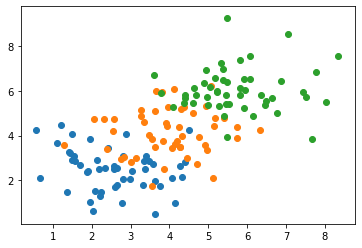

In [62]:
x1 = np.random.normal(np.repeat(2.5,K),np.repeat(1,K), [N,K])
x2 = np.random.normal(np.repeat(4,K),np.repeat(1,K), [N,K])
x3 = np.random.normal(np.repeat(6,K),np.repeat(1,K), [N,K])
#x2 = np.random.normal([4,4],[1,1], [N,2])
#x3 = np.random.normal([6,6],[1,1], [N,2])
if(K==2):
    plt.scatter(x1[:,0], x1[:,1])
    plt.scatter(x2[:,0], x2[:,1])
    plt.scatter(x3[:,0], x3[:,1])
    plt.show()

In [63]:
x_0 = np.concatenate([x1, x2, x3])
y_0 = np.concatenate([np.zeros(N), np.ones(N), np.ones(N)+np.ones(N)]).astype(int)

In [64]:
x_0.shape, y_0.shape


((150, 2), (150,))

In [65]:
#import theano.tensor as tt

In [66]:
with pm.Model() as model_0:
    alpha = pm.Normal('alpha', mu=0, sigma=10, shape=M)
    beta = pm.Normal('beta1', mu=0, sigma=10, shape=(K,M))
    
    mu = alpha + pm.math.dot(x_0, beta)
    theta = pm.math.softmax(mu)
    #p = pm.Deterministic('p', tt.nnet.softmax(mu))
    yl = pm.Categorical('yl', p=theta, observed=y_0)
    #yl = pm.Categorical('yl', p=p, observed=y_0)


    start = pm.find_MAP()
    step = pm.NUTS()
    trace_0 = pm.sample(5000, step, start)

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, beta1]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 273 seconds.


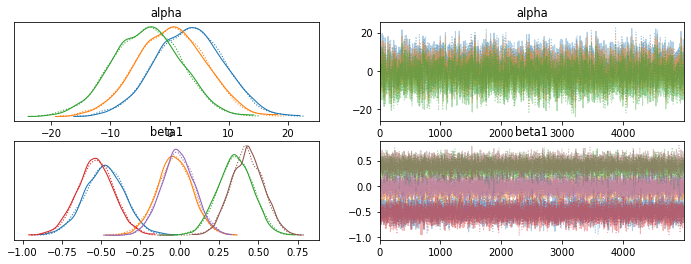

<Figure size 432x288 with 0 Axes>

In [67]:
varnames = ['alpha', 'beta']
az.plot_trace(trace_0)#, varnames)
plt.show()
plt.tight_layout()
plt.show()

In [68]:
model_0

In [72]:
trace_0['alpha']

KeyError: 'alpha'

In [71]:
data_pred = trace_0['alpha'].mean(axis=0) + np.dot(x_0, trace_0['beta'].mean(axis=0))
y_pred = []
for point in data_pred:
    y_pred.append(np.exp(point)/np.sum(np.exp(point), axis=0))
np.sum(y_0==np.argmax(y_pred, axis=1))/len(y_0)

KeyError: 'alpha'